In [9]:
nest = True
target_y = 1273

In [36]:
from dask.distributed import Client
client = Client(n_workers=12, threads_per_worker=1, memory_limit='7GB')
# print the dashboard link
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 12,Total memory: 78.23 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37381,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 78.23 GiB
Comm: tcp://127.0.0.1:46375,Total threads: 1
Dashboard: http://127.0.0.1:40467/status,Memory: 6.52 GiB
Nanny: tcp://127.0.0.1:45485,


In [37]:
import xarray as xr
import numpy as np
from pathlib import Path
import gsw
from xarray import open_mfdataset, open_dataset
from matplotlib import pyplot as plt



# Utilities 
def find_grid_files(grid_type, years, nest, model, delta_t, folder = 'output'): 
    experiment_path = Path('/gxfs_work/geomar/smomw355/model_data/ocean-only/')
    nest_part = '1_' if nest else '' 

    if len(grid_type) < 2:
        grid_type = f'grid_{grid_type}'

    grid_files = (experiment_path / model / 'nemo' / folder).glob(f'{nest_part}{model}_{delta_t}_*_*_{grid_type}.nc')
    grid_files = list(grid_files)
    
    result_files = []
    for file in grid_files:
        start_year = int(str(file).split('/')[-1].split('_')[- (3 + grid_type.count('_'))][:4])
        
        if (years[0] is None or start_year >= years[0]) and \
           (years[1] is None or start_year < years[1]):
            result_files.append(file)
    
    return sorted(result_files)

def load_dataset_from_grid_type(grid_type, years, nest, model, delta_t, chunks = {"time_counter" : 2,"y": 2, "x": None}, **kwargs):
    files_list = find_grid_files(grid_type, years, nest, model, delta_t, **kwargs)
    grid = open_mfdataset(
        files_list, # type: ignore
        chunks= chunks,
        combine='by_coords'
    )
    return grid

def load_masks(nest, model):

    if str.startswith(model, 'VIKING20X.L46-KFS003'):
        # All the mask for the long runs VIKING20X.L46-KFS003-2nd, ... are placed in the original experiment
        model = 'VIKING20X.L46-KFS003' 
    
    nest_part = '1_' if nest else ''
    
    mask_mesh = open_dataset(
        f'/gxfs_work/geomar/smomw355/model_data/ocean-only/{model}/nemo/suppl/{nest_part}mesh_mask.nc',
        decode_cf=False,
        chunks={'y': 100, 'x':100, 'z': -1},
    )

    if model == 'VIKING20X.L46-KFS003' and not nest:
        nest_part = 'ori_'

    mask_glo = open_dataset(
        f'/gxfs_work/geomar/smomw355/model_data/ocean-only/{model}/nemo/suppl/{nest_part}new_maskglo.nc',
        decode_cf=False,
        chunks={'Y':100, 'X':100, 'z': -1}
    )

    mask_mesh = mask_mesh.squeeze()
    mask_glo = mask_glo.rename({'X':'x', 'Y':'y'}).squeeze() # Rename coordinates to have the same name as the data file
    
    return mask_mesh, mask_glo



## Xarray Implementation

In [38]:

ds_T = load_dataset_from_grid_type('T', (1970, 1971), nest, 'VIKING20X.L46-KFS003', '1m', chunks={'x': 100, 'y': 100, 'time_counter': 1, 'deptht': -1})

ds_V = load_dataset_from_grid_type('V', (1970, 1971), nest, 'VIKING20X.L46-KFS003', '1m', chunks={'x': 100, 'y': 100, 'time_counter': 1, 'deptht': -1})

# ds_T = ds_T.isel(time_counter=0, drop=True)
ds_T = ds_T.rename({"deptht": "z"})
ds_T = ds_T.assign_coords(x=np.arange(ds_T.dims["x"]), y=np.arange(ds_T.dims["y"]))

ds_V = ds_V.rename({"depthv": "z"})
ds_V = ds_V.assign_coords(x=np.arange(ds_V.dims["x"]), y=np.arange(ds_V.dims["y"]))
ds_T

<xarray.Dataset>
Dimensions:               (y: 2499, x: 2404, z: 46, axis_nbounds: 2,
                           time_counter: 12)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
  * z                     (z) float32 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 1970-01-16T12:00:00 ....
  * x                     (x) int64 0 1 2 3 4 5 ... 2399 2400 2401 2402 2403
  * y                     (y) int64 0 1 2 3 4 5 ... 2494 2495 2496 2497 2498
Dimensions without coordinates: axis_nbounds
Data variables: (12/18)
    deptht_bounds         (z, axis_nbounds) float32 dask.array<chunksize=(46, 2), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    votemper              (time_counter, z, y, x) float32 dask.array<chunksize=(1, 46, 100, 100), meta=np.ndarray>
    vosaline              (time_counter, z, y, x) float32 dask.array<chunksize=(1, 46, 100, 100), meta=np.ndarray>
    sosstsst              (time_counter, y, x) float32 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    ...                    ...
    sohefldo              (time_counter, y, x) float32 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    somixhgt              (time_counter, y, x) float32 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    sowindsp              (time_counter, y, x) float32 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    sohefldp              (time_counter, y, x) float32 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    sowafldp              (time_counter, y, x) float32 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    sobowlin              (time_counter, y, x) float32 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
Attributes:
    name:         /p/scratch/viking/schwarzkopf1/VIKING20X.L46/VIKING20X.L46-...
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2020-Dec-19 08:20:04 GMT
    uuid:         84af2a2f-fbb6-49dc-bcad-3da2e42d5791
    history:      Tue Dec 22 10:56:31 2020: ncrcat 1_VIKING20X.L46-KFS003_1m_...
    NCO:          netCDF Operators version 4.9.6 (Homepage = http://nco.sf.ne...

In [39]:
ds_m, ds_mask = load_masks(nest, 'VIKING20X.L46-KFS003')
ds_m = ds_m.assign_coords(x=np.arange(ds_m.dims["x"]), y=np.arange(ds_m.dims["y"]))
# ds_mask = ds_mask.rename({"X": "x", "Y": "y"})
ds_mask = ds_mask.assign_coords(x=np.arange(ds_mask.dims["x"]), y=np.arange(ds_mask.dims["y"]))

In [40]:
pot_temp = ds_T.votemper
salinity = ds_T.vosaline

pot_temp = pot_temp.where((ds_m.tmask == 1) & (ds_m.tmaskutil == 1))
salinity = salinity.where((ds_m.tmask == 1) & (ds_m.tmaskutil == 1))

ct = gsw.CT_from_pt(salinity, pot_temp)
rho = gsw.rho(salinity, ct, ds_T.z).rename("dens")

In [41]:
drho_dx = (rho.diff("x") / ds_m.e1t).rename("drho_dx")

f = 2 * 7.2921e-5 * np.sin(np.deg2rad(ds_m.gphit))
f = f.where(abs(ds_m.gphit) > 5)
g = 9.81

dv_dz = - g / f / rho * drho_dx

v = (dv_dz * ds_m.e3t_0).isel(z=slice(None, None, -1)).cumsum("z").isel(z=slice(None, None, -1))
v = v.where(~dv_dz.isnull())
dvbt = ((ds_m.e3v_0 * ds_m.vmask) * ds_V.vomecrty).sum('z')
depth = (ds_m.e3v_0 * ds_m.vmask).sum('z')
dvbt = dvbt /depth

dvbt = dvbt.where(ds_mask.tmaskatl == 1)

amoc_bt = dvbt * (ds_m.e1v * ds_m.e3v_0 * ds_m.vmask)
amoc_bt = (-amoc_bt).sum('x')


amoc_sh = (v.where(ds_mask.tmaskatl == 1) * ds_m.e1t * ds_m.e3t_0).sum("x")

amoc = (amoc_sh - amoc_bt).isel(z=slice(None, None, -1)).cumsum("z").isel(z=slice(None, None, -1))
amoc

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=

<xarray.DataArray (y: 2499, time_counter: 12, z: 46)>
dask.array<getitem, shape=(2499, 12, 46), dtype=float64, chunksize=(100, 1, 46), chunktype=numpy.ndarray>
Coordinates:
  * y              (y) int64 0 1 2 3 4 5 6 ... 2493 2494 2495 2496 2497 2498
  * z              (z) float32 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
  * time_counter   (time_counter) datetime64[ns] 1970-01-16T12:00:00 ... 1970...
    time_centered  (time_counter) datetime64[ns] 1970-01-16T12:00:00 ... 1970...
    T              float64 1.0

In [42]:
geo_moc_calc = (amoc / 1e6).rename("Geostrophic AMOC [Sv]").isel(y = target_y, z = 24).compute()

/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/gxfs_home/geomar/smomw507/.conda/envs/amoc_recons/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a

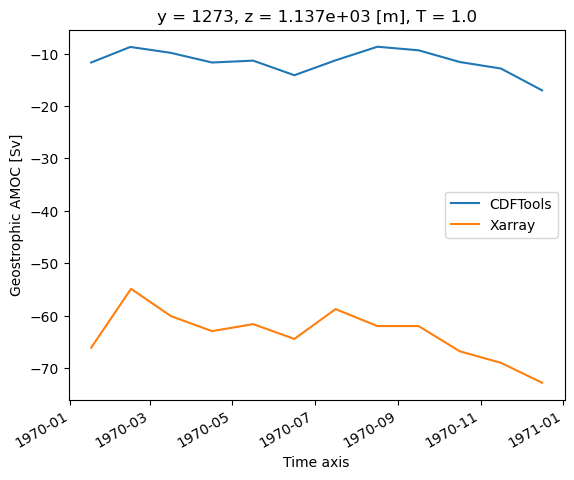

In [48]:
geo_moc = load_dataset_from_grid_type('moc', (1970, 1971), nest, 'VIKING20X.L46-KFS003', '1m', chunks={'y': 100, 'time_counter': 1}, folder = 'derived')

geo_moc.zomsfatl_sh.isel(y = target_y, depthw = 24).plot(label = 'CDFTools')
# geo_moc.zomsfatl_ageo.isel(y = target_y, depthw = 24).plot()
geo_moc_calc.plot(label = "Xarray")
plt.legend()



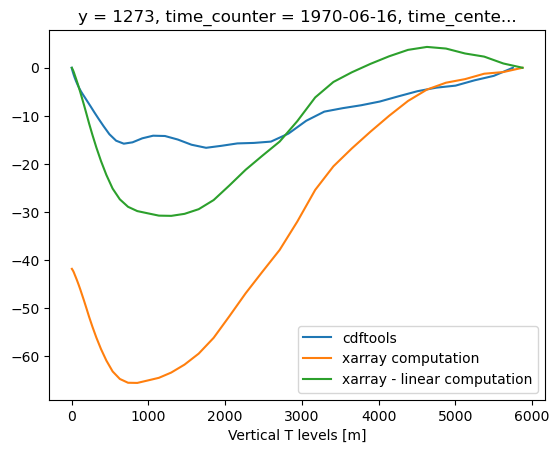

In [50]:
cdftools_profile = geo_moc.zomsfatl_sh.isel(time_counter = 5, y = 1273)
cdftools_profile = cdftools_profile.assign_coords(depthw=-cdftools_profile.depthw)
cdftools_profile.plot(label = 'cdftools')
moc_calc = (amoc / 1e6).rename("Geostrophic AMOC [Sv]").isel(y = 1273, time_counter = 5)

moc_calc.plot(label = 'xarray computation')
linear = moc_calc.isel(z = 0) + (moc_calc.isel(z = -1) - moc_calc.isel(z = 0)) / moc_calc.z.isel(z = -1) * moc_calc.z 

(moc_calc - linear).plot(label = 'xarray - linear computation')

plt.legend()

# Calculate like CDF Tools from Density

In [14]:
import xarray as xr
import numpy as np

rho = xr.open_dataset('/gxfs_work/geomar/smomw507/geomar/amoc-reconstruction/data/cdfgeostrophic/1_VIKING20X.L46-KFS003_1m_19700101_19701231_dens.nc', chunks={'y': 100, 'x':100, 'time_counter': 1})
rho = rho.rename({"deptht": "z"})
rho = rho.assign_coords(x=np.arange(rho.dims["x"]), y=np.arange(rho.dims["y"]))

rho = rho.vosigmainsitu


In [15]:
ds_m, ds_mask = load_masks(nest, 'VIKING20X.L46-KFS003')
ds_m = ds_m.assign_coords(x=np.arange(ds_m.dims["x"]), y=np.arange(ds_m.dims["y"]))
ds_mask = ds_mask.assign_coords(x=np.arange(ds_mask.dims["x"]), y=np.arange(ds_mask.dims["y"]))

## Numpy Implementation

In [25]:
dens_all_t = rho.transpose('time_counter', 'x', 'y', 'z').values
tmask = ds_m.tmask.transpose('x', 'y', 'z').values
umask = ds_m.umask.transpose('x', 'y', 'z').values
vmask = ds_m.vmask.transpose('x', 'y', 'z').values
e1u = ds_m.e1u.transpose('x', 'y').values
e1v = ds_m.e1v.transpose('x', 'y').values
e3v = ds_m.e3v_0.transpose('x', 'y', 'z').values
gphiv = ds_m.gphiv.transpose('x', 'y').values
tmaskatl = ds_mask.tmaskatl.transpose('x', 'y').values

In [26]:
rpi = np.arccos(-1)

zcoef = 2*2*rpi/( 24.0 * 3600. )* np.sin ( rpi * gphiv /180.0)
zcoef = np.where(np.abs(gphiv) > 5, zcoef, np.nan)

zcoef = np.where(zcoef != 0, -9.81 / 1025.0 / zcoef, 0.0)

In [28]:
amoc = np.empty(shape = (dens_all_t.shape[0], dens_all_t.shape[2], dens_all_t.shape[3]))
for ti, dens in enumerate(dens_all_t): 

    diff = np.diff(dens, axis = 0)

    # multiply elementwise with the u mask and divide by the width of the u box
    diff = (np.nan_to_num(diff) * umask[:-1, :, :]) / e1u[:-1, :, np.newaxis]

    drho = np.zeros_like(dens)
    drho[1:-1, :-1] = diff[:-1, :-1] + diff[1:, :-1] + diff[:-1, 1:] + diff[1:, 1:] 


    zmsv = np.ones_like(dens)
    zmsv[1:, :-1] =umask[1:, :-1] + umask[:-1, :-1] + umask[1:, 1:] + umask[:-1, 1:]
    zmsv = np.where(zmsv > 0, 1 / zmsv, 1)




    dvgeo = drho * zcoef[:,:,np.newaxis] * zmsv * e3v * tmaskatl[:, :, np.newaxis]

    dvgeo = np.where(vmask == 1, dvgeo, np.nan)
    dvgeo = np.nancumsum(dvgeo[..., ::-1], axis = -1)[..., ::-1]

    # move to v level 
    zv = np.zeros_like(dvgeo)
    for zk in range(dvgeo.shape[2] -1, -1, -1):
        if zk == dvgeo.shape[2] -1:
            zv[:,:,zk] = .5 * dvgeo[:,:,zk]
        else:
            zv[:,:,zk] = .5 * (dvgeo[:,:,zk] + dvgeo[:,:,zk + 1])


    zv = np.where(vmask == 1, zv, np.nan)

    dvbt = np.nansum(e3v * zv, axis = -1)
    hdep = np.nansum(e3v, axis = -1)

    dmoc_sh = np.nansum(-e1v[:, :, np.newaxis] * e3v * zv * tmaskatl[:, :, np.newaxis], axis = 0)

    dvbt = np.where(hdep == 0, 0, dvbt / hdep)
    dvbt = np.where(tmaskatl == 1, dvbt, np.nan)

    dmoc_btw = np.nansum(-dvbt[:, :, np.newaxis] * e1v[:, :, np.newaxis] * e3v, axis = 0)

    dmoc_sh = dmoc_sh - dmoc_btw
    dmoc_sh = np.nancumsum(dmoc_sh[:, ::-1], axis = 1)[:, ::-1] / 1e6

    amoc[ti] = dmoc_sh

/scratch/SlurmTMP/smomw507.11088431/ipykernel_3966864/4152968155.py:15: RuntimeWarning: divide by zero encountered in divide
  zmsv = np.where(zmsv > 0, 1 / zmsv, 1)


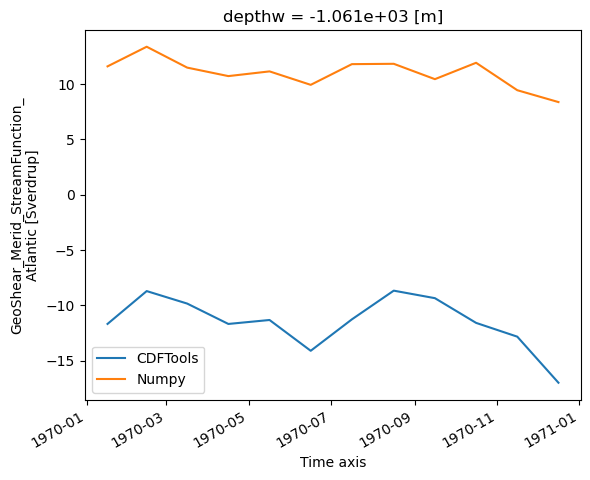

In [31]:
geo_moc = load_dataset_from_grid_type('moc', (1970, 1971), nest, 'VIKING20X.L46-KFS003', '1m', chunks={'y': 100, 'time_counter': 1}, folder = 'derived')

geo_moc.zomsfatl_sh.isel(y = target_y, depthw = 24).plot(label = 'CDFTools')
plt.plot(geo_moc.time_counter,amoc[:, target_y, 24], label = 'Numpy')

plt.legend()


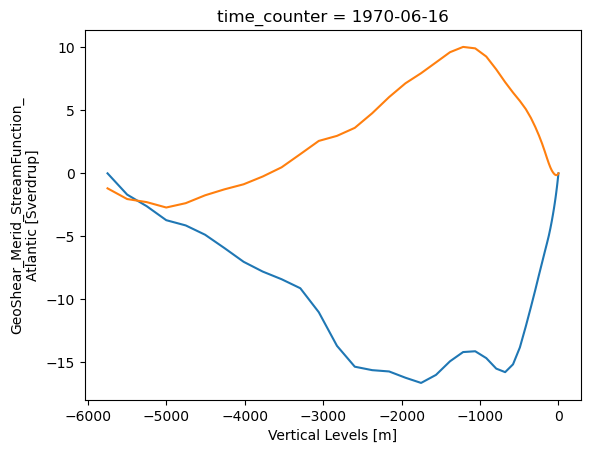

In [33]:

geo_moc.zomsfatl_sh.isel(y = target_y, time_counter = 5).plot(label = 'CDFTools')
plt.plot(geo_moc.depthw, amoc[5, target_y], label = 'Numpy')
plt.legend()